In [ ]:
# 모델 생성 전 total.csv 파일 만들기 (크롤링한 데이터 전부 취합 정리 저장)

In [37]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import mpld3 #!pip install mpld3
import tensorflow as tf

In [ ]:
# total 불러오기
def read_csv_by_dir(path, index_col=None):
    df_raw = pd.DataFrame()
    for files in os.listdir(path):
        if files.endswith('.csv'):
            df = pd.read_csv('/'.join([path,files]),
                            index_col=index_col)
        df_raw = pd.concat((df_raw,df),axis=0)
    return df_raw

path = os.getcwd()
df_rf = read_csv_by_dir('/'.join([path,'competition_data/rf_data']), index_col=0)
df_water = read_csv_by_dir('/'.join([path,'competition_data/water_data']), index_col=0)

def index_to_datetime(df,format):
    df.index = pd.to_datetime(df.index, format=format)
    return df

df_rf=index_to_datetime(df=df_rf,format='%Y-%m-%d %H:%M')
df_water=index_to_datetime(df=df_water,format='%Y-%m-%d %H:%M')

df_rf.sort_index(inplace=True)
df_water.sort_index(inplace=True)

total=pd.concat((df_rf, df_water), axis=1)
total.drop(['fw_1018680'], axis=1, inplace=True)
total=total[['rf_10184100', 'rf_10184110', 'rf_10184140', 'swl', 'inf', 'sfw', 'ecpc', 'tototf', 'tide_level', 'fw_1018662', 'fw_1018683', 'fw_1019630', 'wl_1018662', 'wl_1018680', 'wl_1018683', 'wl_1019630']]
평가_데이터 = pd.read_csv('./competition_data/평가지표데이터.csv')
temp_df = 평가_데이터.iloc[:,-4:]
temp_df = temp_df.set_index(평가_데이터['ymdhm'])
total.loc['2022-06-01 00:00':,:].iloc[:,-4:] = temp_df

total.fillna(total.mean(), inplace=True)
total['inf'].replace(0.0, np.NaN, inplace=True)
total['fw_1018683'].replace(0.0, np.NaN, inplace=True)
total['inf'].interpolate(inplace=True)
total['fw_1018683'].interpolate(inplace=True)
total.to_csv('total.csv')

In [ ]:
# 모델 생성 저장

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import mpld3 #!pip install mpld3
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

total_csv = pd.read_csv('total.csv')
total_csv.set_index('ymdhm', inplace=True)

mms1 = StandardScaler()
mms2 = StandardScaler()
mms1.fit(total_csv.iloc[:,:-1])
mms2.fit(total_csv.iloc[:,-1:])
dataset1 = mms1.transform(total_csv.iloc[:,:-1])
dataset2 = mms2.transform(total_csv.iloc[:,-1:])
dataset=np.concatenate([dataset1, dataset2], axis=1)

def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step = False):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    return np.array(data), np.array(labels)

In [293]:
past_history = 6*24*5 # 5일 데이터 = 6*24*5
future_target = 36 # 예측 n*10분 36일땐 6시간
STEP = 24 # 메모리가 부족할 땐 높게
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EPOCHS2 = 5
EVALUATION_INTERVAL = 200

x_real = dataset[-6120:,]

x_real_array, _ = multivariate_data(x_real, x_real[:, -1], 0, None, past_history, future_target, STEP)
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:,-1], 0, 269424, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:,-1], 269424, None, past_history, future_target, STEP)

In [301]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [304]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D, Dropout, TimeDistributed
from keras.layers import Bidirectional
multi_step_model = Sequential()
multi_step_model.add((LSTM(256, input_shape=(x_train_multi.shape[-2:]), return_sequences = True)))
multi_step_model.add(Bidirectional(LSTM(128, activation = 'relu')))
multi_step_model.add(Dense(64, activation = 'relu'))
multi_step_model.add(Dense(36))
optimizer = tf.optimizers.Adam(clipvalue = 0.1)
multi_step_model.compile(optimizer=optimizer,loss='mse')
multi_step_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 30, 256)           279552    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_17 (Dense)             (None, 36)                2340      
Total params: 692,580
Trainable params: 692,580
Non-trainable params: 0
_________________________________________________________________


In [307]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs = EPOCHS2, steps_per_epoch = EVALUATION_INTERVAL, validation_data = val_data_multi, validation_steps = 50)

Epoch 1/5
200/200 [==============================] - 54s 259ms/step - loss: 0.2285 - val_loss: 0.3316
Epoch 2/5
200/200 [==============================] - 47s 233ms/step - loss: 0.0463 - val_loss: 0.2585
Epoch 3/5
200/200 [==============================] - 65s 324ms/step - loss: 0.0581 - val_loss: 0.1548
Epoch 4/5
200/200 [==============================] - 53s 265ms/step - loss: 0.0399 - val_loss: 0.1578
Epoch 5/5
200/200 [==============================] - 77s 386ms/step - loss: 0.0514 - val_loss: 0.1624


In [308]:
pred1 = multi_step_model.predict(x_real_array)
real1 = mms2.inverse_transform(pred1[-1])

In [341]:
future_df = pd.read_csv(path + '/competition_data/종합7.19_.csv')
future_df.index = future_df['ymdhm']
future_df.index = pd.to_datetime(future_df.index, format='%Y-%m-%d %H:%M')
future_df.index = future_df.index.to_period('T')
future_df.drop(['ymdhm'], axis = 1, inplace = True)

36

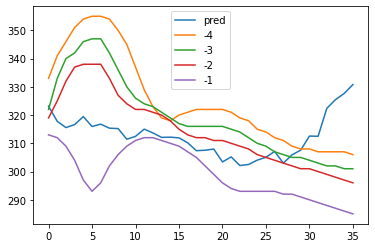

In [342]:
plt.plot(range(36),real1, label = 'pred')
plt.plot(range(36),np.array(future_df.loc[:'2022-07-19 11:50:00'].iloc[:,-4])[:36], label='-4')
plt.plot(range(36),np.array(future_df.loc[:'2022-07-19 11:50:00'].iloc[:,-3])[:36], label='-3')
plt.plot(range(36),np.array(future_df.loc[:'2022-07-19 11:50:00'].iloc[:,-2])[:36], label='-2')
plt.plot(range(36),np.array(future_df.loc[:'2022-07-19 11:50:00'].iloc[:,-1])[:36], label='-1')
plt.legend()

In [ ]:
multi_step_model.save('행주대교')

In [ ]:
# 모델 불러와서 예측 및 그래프 html로 저장

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import database
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [46]:
# load_model = tf.keras.models.load_model('잠수교6시간후예측모델')
load_model = tf.keras.models.load_model('model')
db = database.SqliteDb()
db.connect('water.db')
# df = db.get_dataframe('water_collection')
df = db.get_dataframe('water_total')
# df.drop('index', axis=1, inplace=True)
df.drop('idx', axis=1, inplace=True)
df.set_index('ymdhm', inplace=True)

In [47]:
total_csv = pd.read_csv('total.csv')
total_csv.set_index('ymdhm', inplace=True)
mms1 = StandardScaler()
mms2 = StandardScaler()
mms1.fit(total_csv.iloc[:,:-1])
mms2.fit(total_csv.iloc[:,-1:])

dataset1 = mms1.transform(df.iloc[:,:-1])
dataset2 = mms2.transform(df.iloc[:,-1:])
dataset=np.concatenate([dataset1, dataset2], axis=1)

In [48]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step = False):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    return np.array(data), np.array(labels)

In [49]:
past_history = 6*24*5 # 5일 데이터 = 6*24*5
future_target = 36 # 예측 n*10분 36일땐 6시간
STEP = 24 # 메모리가 부족할 땐 높게
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EPOCHS2 = 5
EVALUATION_INTERVAL = 200

x_real = dataset[-6120:,]
x_real_array, _ = multivariate_data(x_real, x_real[:, -1], 0, None, past_history, future_target, STEP)

In [51]:
pred = load_model.predict(x_real_array)
future_array = mms2.inverse_transform(pred[-1])

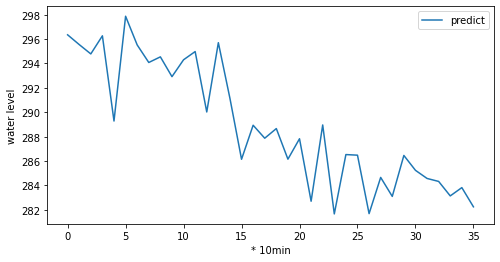

In [53]:
fig = plt.figure(figsize=(8,4))
# plt.plot(range(36), real, label='real')
plt.plot(range(36), future_array, label='predict')
plt.xlabel('* 10min')
plt.ylabel('water level')
plt.legend()
with open("pred_행주대교.html", "w") as f:
    f.write(mpld3.fig_to_html(fig, figid='level'))